# Analyse der Themenbereiche (Latent Dirichlet Allocation)

In [1]:
#Import Bibliothek
import pandas as pd
import nltk
from nltk.corpus import stopwords
from gensim.corpora import Dictionary
from gensim.models.ldamodel import LdaModel, CoherenceModel
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt

C:\Users\MarkE\AppData\Roaming\Python\Python310\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
#Abruf Daten 
file_path = file_path = r'5_Inhaltsanalyse_nach_NER.csv'

df = pd.read_csv(file_path)
print(df.head())

  Quelle       Datum                                               Link  \
0    FAZ  11/30/2023  https://www.faz.net/aktuell/wirtschaft/unterne...   
1    FAZ  11/30/2023  https://www.faz.net/aktuell/wirtschaft/kuenstl...   
2    FAZ  11/29/2023  https://www.faz.net/aktuell/feuilleton/medien/...   
3    FAZ  11/28/2023  https://www.faz.net/pro/d-economy/kuenstliche-...   
4    FAZ  11/28/2023  https://www.faz.net/pro/d-economy/prompt-der-w...   

                                               Titel  \
0  KI: Warum wir nicht mit Roboter-Autos vollauto...   
1  Microsoft: Sind Jahrzehnte von einer künstlich...   
2  Künstliche Intelligenz: Europa muss von neuen ...   
3  Was die Superintelligenz-KI anrichten könnte, ...   
4  Künstliche Intelligenz: Wie man sich seine Pro...   

                                                Text  Anzahl Woerter Text  \
0  Roboterautos faszinieren viele – die Augen der...                 1963   
1  Der Krieg von Mensch gegen Maschine verschiebt...      

In [3]:
#Stellen Sie sicher, dass jeder Eintrag eine Liste von Wörtern ist
df['Text_bereinigt_LDA'] = df['Text_bereinigt'].apply(lambda x: x.split() if isinstance(x, str) else x)

In [4]:
#Latent Dirichlet Allocation (LDA) Model basierend auf bereinigten Artikeltext

#Initialisiere NLTK's Stopwoerter
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Erstelle ein Woerterbuch und Korpus für LDA
# Stelle sicher, dass jedes Dokument eine Liste von Woertern ist
texts = [[word for word in document.lower().split() if word not in stop_words]
         for document in df['Text_bereinigt_LDA'].astype(str)]
dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

#Konstanten für LDA Modellparameter
RANDOM_STATE = 3
UPDATE_EVERY = 3
CHUNKSIZE = 30
PASSES = 15

#Variablen zur Speicherung des besten Modells und des höchsten Coherence Score
best_model = None
best_score = 0
best_params = {}

#Loop über die Anzahl der Themen
for num_topics in range(3, 21):
    lda = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, random_state=RANDOM_STATE,
                   update_every=UPDATE_EVERY, chunksize=CHUNKSIZE, passes=PASSES, alpha='auto')
    coherence_model = CoherenceModel(model=lda, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model.get_coherence()

    print(f"Anzahl Themen: {num_topics}, Kohaerenz-Score: {coherence_score}")

    if coherence_score > best_score:
        best_score = coherence_score
        best_model = lda
        best_params = {'num_topics': num_topics, 'random_state': RANDOM_STATE, 'update_every': UPDATE_EVERY, 'chunksize': CHUNKSIZE, 'passes': PASSES}

#Funktion, um die Top 25 Woerter pro Thema anzuzeigen inklusive Konfidenz-Werten
def print_top_words_per_topic_with_confidence(lda_model, num_topics, num_words=25):
    for i in range(num_topics):
        top_words = lda_model.show_topic(i, num_words)
        words_with_confidence = ', '.join([f"'{word}' ({prop:.3f})" for word, prop in top_words])
        print(f"Top {num_words} Woerter für Thema #{i}: {words_with_confidence}")

#Top 25 Woerter für jedes Thema anzeigen
print_top_words_per_topic_with_confidence(best_model, num_topics=best_params['num_topics'])

print("Bester Kohaerenz-Score:", best_score)
print("Beste Model Parameter:", best_params)

def assign_lda_topics_and_confidences(words):
    #words wird hier direkt als Liste von Woertern übergeben
    bow = dictionary.doc2bow(words)
    topic_distribution = best_model.get_document_topics(bow, minimum_probability=0.01)
    topic_distribution = sorted(topic_distribution, key=lambda x: x[1], reverse=True)
    
    if len(topic_distribution) > 1:
        dominant_topic, dominant_confidence = topic_distribution[0]
        additional_topics = [(topic, round(confidence, 3)) for topic, confidence in topic_distribution[1:]]
    else:
        dominant_topic, dominant_confidence = topic_distribution[0]
        additional_topics = []

    return dominant_topic, dominant_confidence, additional_topics

df['Text_bereinigt_LDA'] = df['Text_bereinigt_LDA'].astype(str).apply(lambda x: x.lower().split())

df['LDA_thema_dominant'], df['LDA_konfidenz'], df['LDA_thema_weitere'] = zip(*df['Text_bereinigt_LDA'].apply(assign_lda_topics_and_confidences))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\MarkE\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Anzahl Themen: 3, Kohaerenz-Score: 0.33919256903144807
Anzahl Themen: 4, Kohaerenz-Score: 0.3715746195623807
Anzahl Themen: 5, Kohaerenz-Score: 0.3972768393976011
Anzahl Themen: 6, Kohaerenz-Score: 0.3957710347268261
Anzahl Themen: 7, Kohaerenz-Score: 0.37932545685857644
Anzahl Themen: 8, Kohaerenz-Score: 0.4229121835375963
Anzahl Themen: 9, Kohaerenz-Score: 0.42958030426131094
Anzahl Themen: 10, Kohaerenz-Score: 0.40886431608636487
Anzahl Themen: 11, Kohaerenz-Score: 0.4206849049006555
Anzahl Themen: 12, Kohaerenz-Score: 0.4276858775476524
Anzahl Themen: 13, Kohaerenz-Score: 0.4139142750270901
Anzahl Themen: 14, Kohaerenz-Score: 0.48755856414727355
Anzahl Themen: 15, Kohaerenz-Score: 0.47409801729085416
Anzahl Themen: 16, Kohaerenz-Score: 0.45894446679595846
Anzahl Themen: 17, Kohaerenz-Score: 0.48382262819865596
Anzahl Themen: 18, Kohaerenz-Score: 0.4621445505580914
Anzahl Themen: 19, Kohaerenz-Score: 0.3991149446025159
Anzahl Themen: 20, Kohaerenz-Score: 0.42852219497654964
Top 25 W

In [5]:
'''
Titel der Themengebiete mit Hilfe von ChatGPT

Thema 0: Anomalie-Daten und Nischenbegriffe
Thema 1: KI-Markt und Wirtschaft
Thema 2: Führungskräfte und Unternehmen in KI
Thema 3: Film und Unterhaltung
Thema 4: KI-Modelle und Chatbots
Thema 5: Allgemeine KI-Diskussionen
Thema 6: Hochschulbildung und KI
Thema 7: Logistik und KI-Ethik
Thema 8: Gesetzgebung und KI-Regulierung
Thema 9: KI-Forschung und -Anwendungen
Thema 10: Journalismus und Medien
Thema 11: Deutsche KI-Politik und Industrie
Thema 12: KI-gestützte Bild- und Videogenerierung
Thema 13: Bildung und KI-Nutzung


https://chatgpt.com/share/12126c92-a450-45e7-9e60-4601dc2be0c8
'''

'\nTitel der Themengebiete mit Hilfe von ChatGPT\n\nThema 0: Anomalie-Daten und Nischenbegriffe\nThema 1: KI-Markt und Wirtschaft\nThema 2: Führungskräfte und Unternehmen in KI\nThema 3: Film und Unterhaltung\nThema 4: KI-Modelle und Chatbots\nThema 5: Allgemeine KI-Diskussionen\nThema 6: Hochschulbildung und KI\nThema 7: Logistik und KI-Ethik\nThema 8: Gesetzgebung und KI-Regulierung\nThema 9: KI-Forschung und -Anwendungen\nThema 10: Journalismus und Medien\nThema 11: Deutsche KI-Politik und Industrie\nThema 12: KI-gestützte Bild- und Videogenerierung\nThema 13: Bildung und KI-Nutzung\n\n\nhttps://chatgpt.com/share/12126c92-a450-45e7-9e60-4601dc2be0c8\n'

In [6]:
print(df.head())

selected_columns = ['Titel', 'Text_bereinigt_LDA', 'LDA_thema_dominant', 'LDA_konfidenz', 'LDA_thema_weitere']
df_selected = df[selected_columns]

#Ausgabe des DataFrame mit den gewünschten Spalten
print(df_selected)

  Quelle       Datum                                               Link  \
0    FAZ  11/30/2023  https://www.faz.net/aktuell/wirtschaft/unterne...   
1    FAZ  11/30/2023  https://www.faz.net/aktuell/wirtschaft/kuenstl...   
2    FAZ  11/29/2023  https://www.faz.net/aktuell/feuilleton/medien/...   
3    FAZ  11/28/2023  https://www.faz.net/pro/d-economy/kuenstliche-...   
4    FAZ  11/28/2023  https://www.faz.net/pro/d-economy/prompt-der-w...   

                                               Titel  \
0  KI: Warum wir nicht mit Roboter-Autos vollauto...   
1  Microsoft: Sind Jahrzehnte von einer künstlich...   
2  Künstliche Intelligenz: Europa muss von neuen ...   
3  Was die Superintelligenz-KI anrichten könnte, ...   
4  Künstliche Intelligenz: Wie man sich seine Pro...   

                                                Text  Anzahl Woerter Text  \
0  Roboterautos faszinieren viele – die Augen der...                 1963   
1  Der Krieg von Mensch gegen Maschine verschiebt...      

In [7]:
#Speichern des geänderten DataFrame in einer neuen CSV-Datei
df.to_csv('9_Daten_nach_LDA_V2.csv', index=False)

In [8]:
#Themengebietsanalyse - Themengebiete vor und nach ChatGPT

#Gruppieren nach 'LDA_thema_dominant' und 'Jahr.Monat' und Berechnen der verschiedenen Statistiken
lda_chatgpt = df.groupby(['LDA_thema_dominant', 'Zeitraum']).agg(
    Anzahl=('LDA_thema_dominant', 'size'),
).reset_index()

#Berechnen der Summe pro Zeitraum
summe_pro_zeitraum = lda_chatgpt.groupby('Zeitraum')['Anzahl'].transform('sum')

#Berechnen des Prozentsatzes 
lda_chatgpt['Prozent'] = (lda_chatgpt['Anzahl'] / summe_pro_zeitraum) * 100

# Sortieren des DataFrames nach Thema
lda_chatgpt = lda_chatgpt.sort_values(by=['LDA_thema_dominant','Zeitraum'])

#Ausgabe des Resultats
print(lda_chatgpt)

    LDA_thema_dominant         Zeitraum  Anzahl    Prozent
0                    1   0. vor ChatGPT      11   7.096774
1                    1  1. ChatGPT-Jahr      85   7.215620
2                    1  2. ChatGPT-Jahr     102  14.245810
3                    2  1. ChatGPT-Jahr      57   4.838710
4                    2  2. ChatGPT-Jahr      14   1.955307
5                    4  1. ChatGPT-Jahr      87   7.385399
6                    4  2. ChatGPT-Jahr      38   5.307263
7                    5   0. vor ChatGPT     110  70.967742
8                    5  1. ChatGPT-Jahr     642  54.499151
9                    5  2. ChatGPT-Jahr     349  48.743017
10                   8   0. vor ChatGPT       5   3.225806
11                   8  1. ChatGPT-Jahr     135  11.460102
12                   8  2. ChatGPT-Jahr      95  13.268156
13                   9   0. vor ChatGPT      27  17.419355
14                   9  1. ChatGPT-Jahr     137  11.629881
15                   9  2. ChatGPT-Jahr      92  12.8491

     LDA_thema_dominant Jahr.Monat  Anzahl    Prozent
0                     1    2022-01       2  12.500000
1                     1    2022-03       1  10.000000
2                     1    2022-04       1  11.111111
3                     1    2022-09       1   8.333333
4                     1    2022-10       6  26.086957
..                  ...        ...     ...        ...
141                  13    2023-05       6   4.545455
142                  13    2023-07       1   1.041667
143                  13    2023-11       1   0.505051
144                  13    2024-01       1   0.649351
145                  13    2024-04       1   0.609756

[146 rows x 4 columns]


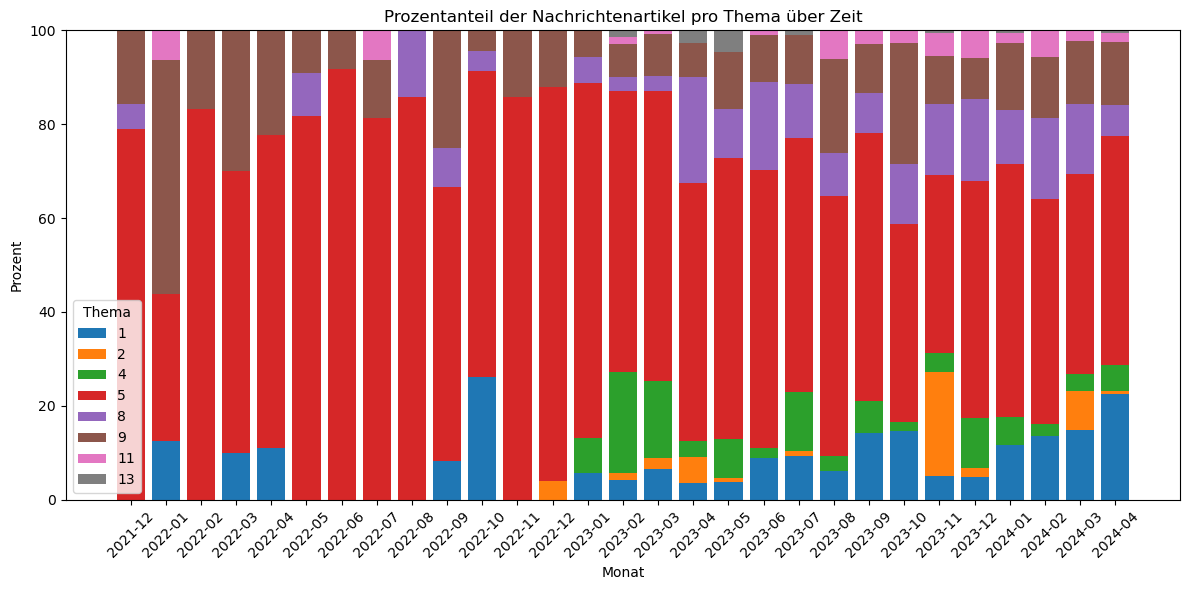

In [9]:
#Themengebietsanalyse - Themengebiete nach Monaten

# Gruppieren nach 'LDA_thema_dominant' und 'Jahr.Monat' und Berechnen der verschiedenen Statistiken
lda_monat = df.groupby(['LDA_thema_dominant', 'Jahr.Monat']).agg(
    Anzahl=('LDA_thema_dominant', 'size'),
).reset_index()

#Berechnen der Summe pro Zeitraum
summe_pro_zeitraum = lda_monat.groupby('Jahr.Monat')['Anzahl'].transform('sum')

#Berechnen des Prozentsatzes 
lda_monat['Prozent'] = (lda_monat['Anzahl'] / summe_pro_zeitraum) * 100

#Ausgabe des Resultats
print(lda_monat)

#Umwandlung von 'Jahr.Monat' in datetime, falls es sich um Period-Objekte handelt
if lda_monat['Jahr.Monat'].dtype == 'period[M]':
    lda_monat['Jahr.Monat'] = lda_monat['Jahr.Monat'].dt.to_timestamp()

#Visualisierung der Daten
plt.figure(figsize=(12, 6))  # Größe des Diagramms anpassen

#Erstelle ein Array von Datumsindizes (x-Achse)
date_indices = lda_monat['Jahr.Monat'].drop_duplicates().sort_values()
num_dates = len(date_indices)

#Erstelle ein Dictionary, um die Höhen der bisherigen Balken zu speichern
heights = {date: 0 for date in date_indices}

#Iteriere über jedes Thema
for thema in lda_monat['LDA_thema_dominant'].unique():
    themen_data = lda_monat[lda_monat['LDA_thema_dominant'] == thema]
    #Sortiere Daten nach Datum für konsistente Anordnung
    themen_data = themen_data.set_index('Jahr.Monat').reindex(date_indices, fill_value=0)
    
    #Zeichne einen Balken für jedes Datum
    plt.bar(themen_data.index, themen_data['Prozent'], bottom=[heights[date] for date in themen_data.index], label=thema)

    #Aktualisiere die Hoehen für die naechsten Balken
    for date in themen_data.index:
        heights[date] += themen_data.at[date, 'Prozent']

plt.title('Prozentanteil der Nachrichtenartikel pro Thema über Zeit')  # Titel des Diagramms
plt.xlabel('Monat')  #X-Achsen-Beschriftung
plt.ylabel('Prozent')  #Y-Achsen-Beschriftung
plt.legend(title='Thema')  #Legende hinzufügen
plt.xticks(rotation=45)  #X-Achsen-Labels drehen, falls notwendig
plt.tight_layout()  #Layout anpassen, um Überlappung zu vermeiden
plt.show()  #Diagramm anzeigen

In [10]:
#Themengebietsanalyse - Themengebiete pro Nachrichtenseite vor und nach ChatGPT
# Gruppieren nach 'LDA_thema_dominant', 'Zeitraum' und 'Quelle'
lda_chatgpt_quelle = df.groupby(['LDA_thema_dominant', 'Zeitraum', 'Quelle']).agg(
    Anzahl=('LDA_thema_dominant', 'size')
).reset_index()

# Berechnen der Gesamtanzahl pro Zeitraum und Quelle
summe_pro_zeitraum_quelle = lda_chatgpt_quelle.groupby(['Zeitraum', 'Quelle'])['Anzahl'].transform('sum')

# Berechnen des Prozentsatzes der Anzahl im Verhaeltnis zur Gesamtanzahl pro Zeitraum und Quelle
lda_chatgpt_quelle['Prozent'] = (lda_chatgpt_quelle['Anzahl'] / summe_pro_zeitraum_quelle) * 100

# Sortieren des DataFrames nach Thema, Quelle und Zeitraum
lda_chatgpt_quelle = lda_chatgpt_quelle.sort_values(by=['Quelle','Zeitraum','LDA_thema_dominant'])

# Ausgabe des Ergebnisses
print(lda_chatgpt_quelle)

     LDA_thema_dominant         Zeitraum Quelle  Anzahl    Prozent
0                     1   0. vor ChatGPT    FAZ       1   3.448276
44                    5   0. vor ChatGPT    FAZ      16  55.172414
68                    8   0. vor ChatGPT    FAZ       4  13.793103
84                    9   0. vor ChatGPT    FAZ       7  24.137931
106                  11   0. vor ChatGPT    FAZ       1   3.448276
..                  ...              ...    ...     ...        ...
67                    5  2. ChatGPT-Jahr   Zeit      38  35.849057
83                    8  2. ChatGPT-Jahr   Zeit      21  19.811321
105                   9  2. ChatGPT-Jahr   Zeit      11  10.377358
121                  11  2. ChatGPT-Jahr   Zeit       6   5.660377
128                  13  2. ChatGPT-Jahr   Zeit       2   1.886792

[129 rows x 5 columns]


In [13]:
#Themengebietsanalyse - Sentiment pro Themengebiet vor und nach ChatGPT

#Gruppiere zuerst nach 'Themengebiet' und dann nach 'Jahr.Monat'
grouped = df.groupby(['LDA_thema_dominant', 'Zeitraum']).agg(
    Anzahl_Artikel=('LDA_thema_dominant', 'size'),  # Zählen der Datensätze
    Polaritaet_text=('Polaritaet Textblob [Text]', 'mean'),  # Durchschnitt der "Polaritaet"
    Subjektivitaet_text=('Subjektivitaet Textblob [Text]', 'mean'),  # Durchschnitt der "Subjektivitaet"
    Polaritaet_titel=('Polaritaet Textblob [Titel]', 'mean'),  # Durchschnitt der "Polaritaet"
    Subjektivitaet_titel=('Subjektivitaet Textblob [Titel]', 'mean')  # Durchschnitt der "Subjektivitaet"
).reset_index()

#Runde alle numerischen Werte auf drei Dezimalstellen
grouped[['Polaritaet_text', 'Subjektivitaet_text', 'Polaritaet_titel', 'Subjektivitaet_titel']] = grouped[['Polaritaet_text', 'Subjektivitaet_text', 'Polaritaet_titel', 'Subjektivitaet_titel']].round(3)

#Durchlaufe alle eindeutigen Themengebiete
for thema in grouped['LDA_thema_dominant'].unique():
    source_data = grouped[grouped['LDA_thema_dominant'] == thema]
    source_data.set_index('Zeitraum', inplace=True)

    print(f"Tabelle für Themengebiet: {thema}")
    print(source_data[['Anzahl_Artikel', 'Polaritaet_text', 'Subjektivitaet_text', 'Polaritaet_titel', 'Subjektivitaet_titel']])

Tabelle für Themengebiet: 1
                 Anzahl_Artikel  Polaritaet_text  Subjektivitaet_text  \
Zeitraum                                                                
0. vor ChatGPT               11            0.073                0.435   
1. ChatGPT-Jahr              85            0.036                0.435   
2. ChatGPT-Jahr             102            0.053                0.426   

                 Polaritaet_titel  Subjektivitaet_titel  
Zeitraum                                                 
0. vor ChatGPT              0.007                 0.246  
1. ChatGPT-Jahr            -0.039                 0.248  
2. ChatGPT-Jahr            -0.009                 0.262  
Tabelle für Themengebiet: 2
                 Anzahl_Artikel  Polaritaet_text  Subjektivitaet_text  \
Zeitraum                                                                
1. ChatGPT-Jahr              57            0.031                0.488   
2. ChatGPT-Jahr              14            0.017                0.495

In [14]:
#Sentiment nach Themengebieten
#Gruppieren nach 'Zeitraum' und Berechnen der erforderlichen Statistiken
result = df.groupby('LDA_thema_dominant').agg(
    Anzahl_Artikel=('Quelle', 'size'),  # Zählen der Datensätze
    Polaritaet_text=('Polaritaet Textblob [Text]', 'mean'),  # Durchschnitt der "Polaritaet"
    Subjektivitaet_text=('Subjektivitaet Textblob [Text]', 'mean'),  # Durchschnitt der "Subjektivitaet"
    Polaritaet_titel=('Polaritaet Textblob [Titel]', 'mean'),  # Durchschnitt der "Polaritaet"
    Subjektivitaet_titel=('Subjektivitaet Textblob [Titel]', 'mean')  # Durchschnitt der "Subjektivitaet"
).reset_index()

#Runden der Ergebnisse auf drei Dezimalstellen
result[['Polaritaet_text', 'Subjektivitaet_text', 'Polaritaet_titel', 'Subjektivitaet_titel']] = result[['Polaritaet_text', 'Subjektivitaet_text', 'Polaritaet_titel', 'Subjektivitaet_titel']].round(3)

print("Zusammenfassung der Daten nach Themenbereiche:")
print(result)

Zusammenfassung der Daten nach Themenbereiche:
   LDA_thema_dominant  Anzahl_Artikel  Polaritaet_text  Subjektivitaet_text  \
0                   1             198            0.047                0.430   
1                   2              71            0.028                0.489   
2                   4             125            0.052                0.469   
3                   5            1101            0.050                0.471   
4                   8             235            0.015                0.448   
5                   9             256            0.050                0.473   
6                  11              49            0.060                0.435   
7                  13              14            0.027                0.471   

   Polaritaet_titel  Subjektivitaet_titel  
0            -0.021                 0.255  
1            -0.073                 0.267  
2            -0.087                 0.272  
3            -0.055                 0.277  
4            -0.129  